In [20]:
import pandas as pd
import numpy as np

# Preprocesado
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# PCA
from sklearn.decomposition import PCA
# Pipelines 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import  cross_val_score, GridSearchCV,cross_validate

import matplotlib.pyplot as plt #plots
import seaborn as sns #more plots


import warnings  # Base category for warnings triggered during the process of importing a module (ignored by default)
warnings.filterwarnings('ignore')  # here we prescribe the action in case of an error.



Load the data, convert variables, imput missings and add the features from featuring enegeneering

In [21]:
data = pd.read_csv('../data/train.csv')
# Make numerical data the target variable
data['Loan_Status'].replace({'Y': 1, 'N': 0},inplace=True)

# drop entries with missing values in 'LoanAmount' and 'Loan_Amount_Term'
data = data.dropna(subset=['LoanAmount', 'Loan_Amount_Term'])

# Make categorical 'Credit_History'
data['Credit_History'].replace({1: 'Y', 0: 'N'}, inplace=True)

# Imput missing values in categorical variables with "DK"
cat_impute_cols = ['Credit_History', 'Married', 'Gender', 'Self_Employed']
for c in cat_impute_cols:
    data[c] = data[c].fillna('DK')

# Create new features
data['Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['LoanInstallment'] = data['LoanAmount'] / data['Loan_Amount_Term']
data['IncomeImpact'] = data['LoanInstallment'] / data['ApplicantIncome']


We select the columns for the different treatments:

In [24]:
# Select variables for PCA
pca_cols = [
    'Income', 'ApplicantIncome', 'CoapplicantIncome',
    'LoanInstallment', 'LoanAmount', 'Loan_Amount_Term', 
    'IncomeImpact'
]

Define pipelines and preprocessors

In [4]:
# Declare the target
target = 'Loan_Status'

# Declare the categorical and numerical cols for the model
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed','Dependents',
                    'Property_Area', 'Credit_History']

# numeric is null because we use the principal components by PCA
numeric_cols = [ ]

In [5]:
pca_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3))
])


In [6]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


In [7]:
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('pca', pca_transformer, pca_cols),
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

We make a cossvalidation for the models with tipical paramters.

In [9]:
X = data.drop(columns=[target])
y = data[target]

models = {
    "Logistic Regression": LogisticRegression(max_iter=200,random_state=43),
    "Random Forest": RandomForestClassifier(random_state=43),
    "Gradient Boosting": GradientBoostingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
    
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    cv_results = cross_validate(
        pipe,
        X,
        y,
        cv=5,
        scoring=['accuracy', 'f1', 'roc_auc','recall'],
        return_train_score=False
    )
    
    results[name] = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'f1': cv_results['test_f1'].mean(),
        'roc_auc': cv_results['test_roc_auc'].mean(),
        'recall': cv_results['test_recall'].mean()
    }


print(pd.DataFrame(results))


          Logistic Regression  Random Forest  Gradient Boosting  CatBoost
accuracy             0.813268       0.794183           0.790705  0.797661
f1                   0.880335       0.863120           0.860414  0.867303
roc_auc              0.759352       0.755705           0.744123  0.758293
recall               0.982654       0.930494           0.925463  0.947840


From this test, *Logistic Regression* seems to be the best option.
Nevertheless, we make a tuning parameter for all models and compare them with roc-auc score.


In [10]:
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=43))
])

params_rf = {
    'model__n_estimators': [200, 500],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_pipe, params_rf, cv=5, scoring='recall', n_jobs=-1)
grid_rf.fit(X, y)

print(grid_rf.best_params_)
print(grid_rf.best_score_)


{'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 500}
0.9776851851851852


In [11]:
cat_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', CatBoostClassifier(verbose=0))
])

params_cat = {
    'model__iterations': [100, 300, 500], 
    'model__depth': [4, 6, 8], 
    'model__learning_rate': [0.01, 0.05], 
    'model__l2_leaf_reg': [1, 5]
}


grid_cat = GridSearchCV(cat_pipe, params_cat, cv=5, scoring='recall', n_jobs=-1)
grid_cat.fit(X, y)

print(grid_cat.best_params_)
print(grid_cat.best_score_)


{'model__depth': 4, 'model__iterations': 100, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.01}
0.9826543209876542


In [12]:
gb_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', GradientBoostingClassifier(random_state=43))
])

params_gb = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [3, 5, 7], 
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0] 
}

grid_gb = GridSearchCV(
    estimator=gb_pipe, 
    param_grid=params_gb, 
    cv=5, 
    scoring='recall', 
    n_jobs=-1
)

grid_gb.fit(X, y)

print(grid_gb.best_params_)
print(grid_gb.best_score_)

{'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
0.9826543209876542


In [13]:
logit_pipe = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', LogisticRegression(max_iter=500))
        ])
params_logit = {
            'model__C': [0.1, 1, 5],
            'model__penalty': ['l2']
        }


grid_logit = GridSearchCV(logit_pipe, params_logit, cv=5, scoring='recall', n_jobs=-1)
grid_logit.fit(X, y)

print(grid_logit.best_params_)
print(grid_logit.best_score_)

{'model__C': 0.1, 'model__penalty': 'l2'}
0.9826543209876542


Due to every model, except random forest, now seems be the best one, we make a new cross validation with the optimal parameters

In [14]:
X = data.drop(columns=[target])
y = data[target]

models = {
    "Logistic Regression": LogisticRegression(
                                            max_iter=200,
                                            C= 0.1, 
                                            penalty='l2'),
    "Random Forest": RandomForestClassifier(max_depth= 5, min_samples_split= 2, n_estimators= 500),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8),
    "CatBoost": CatBoostClassifier(verbose=0,depth=4,iterations=100,l2_leaf_reg=1,learning_rate=0.01)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    cv_results = cross_validate(
        pipe,
        X,
        y,
        cv=5,
        scoring=['accuracy', 'f1', 'roc_auc','recall'],
        return_train_score=False
    )
    
    results[name] = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'f1': cv_results['test_f1'].mean(),
        'roc_auc': cv_results['test_roc_auc'].mean(),
        'recall': cv_results['test_recall'].mean()
    }

pd.DataFrame(results)

,Logistic Regression,Random Forest,Gradient Boosting,CatBoost
accuracy,0.813268,0.808051,0.808066,0.809790
f1,0.880335,0.877057,0.877357,0.878318
roc_auc,0.767643,0.778374,0.752355,0.760504
recall,0.982654,0.980154,0.982654,0.982654


Finally, the best estimator, considering the best parameters, is the logistic regression for 'recall' and most of the metrics, losing by very few in ROC-AUC.

In [15]:
best_model = grid_logit.best_estimator_
best_model.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=3))]),
                                                  ['Income', 'ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanInstallment',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'IncomeImpact']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area',
                                                   'Credit_History'])])),
                ('model', LogisticRegression(C=0.1, max_iter=500))])

Finally, we measure the feature importance

In [16]:
ohe = best_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe']
ohe_features = ohe.get_feature_names_out(categorical_cols)

feature_names = (
    ['PCA1', 'PCA2', 'PCA3'] +
    numeric_cols +
    list(ohe_features)
)


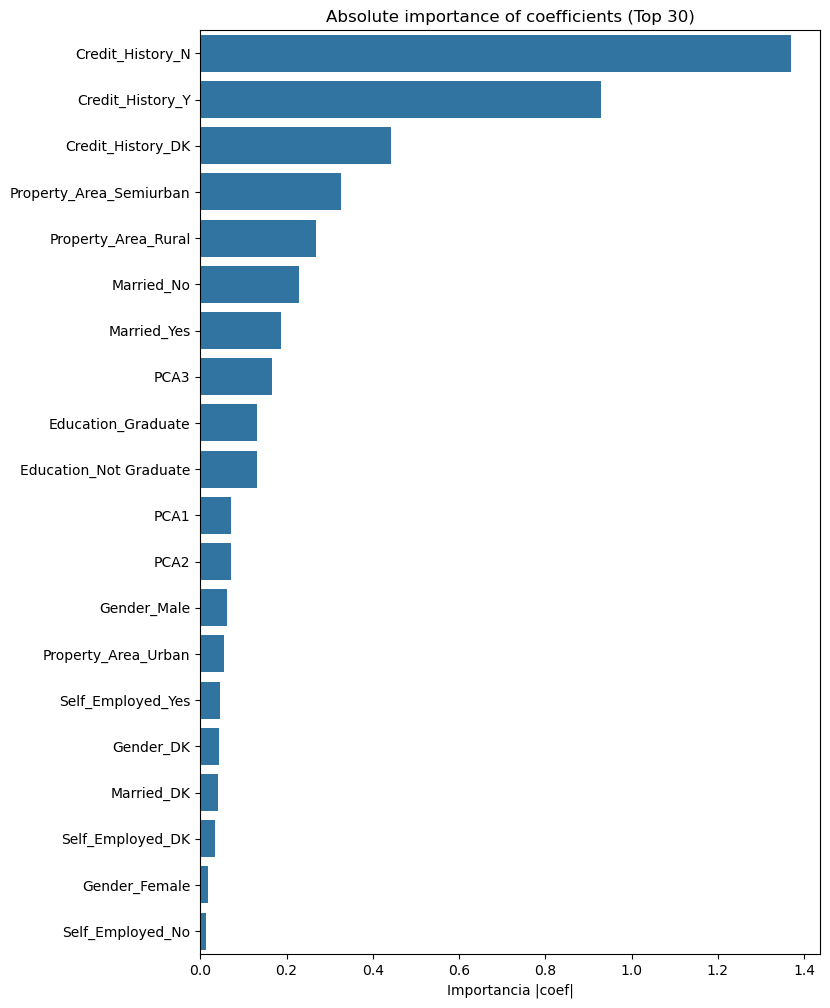

In [17]:
coef = best_model.named_steps['model'].coef_[0]

df = pd.DataFrame({
        'feature': feature_names,
        'coef': coef,
        'importance_abs': np.abs(coef)
    }).sort_values('importance_abs', ascending=False)


plt.figure(figsize=(8, 12))
sns.barplot(y='feature', x='importance_abs', data=df.head(30))
plt.title("Absolute importance of coefficients (Top 30)")
plt.xlabel("Importancia |coef|")
plt.ylabel("")
plt.show()



It is important to note that:
* Credit History is the most relevant factor
* Property Area, marital status and education are the next factors.
* The economic factors seem to be less important than we a priori thought. In the PCA features, all that information is enclosed.
